In [1]:
#Importing all the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_parquet('../input/amex-parquet/train_data.parquet')
train.head()
# train = pd.read_feather('../input/amexfeather/train_data.ftr')
# test = pd.read_feather('../input/amexfeather/test_data.ftr')

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [3]:
train.shape

(5531451, 191)

In [4]:
#printing all the columns and it's datatypes.
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  5531451 non-null  object 
 1    S_2          5531451 non-null  object 
 2    P_2          5485466 non-null  float32
 3    D_39         5531451 non-null  float32
 4    B_1          5531451 non-null  float32
 5    B_2          5529435 non-null  float32
 6    R_1          5531451 non-null  float32
 7    S_3          4510907 non-null  float32
 8    D_41         5529435 non-null  float32
 9    B_3          5529435 non-null  float32
 10   D_42         791314 non-null   float32
 11   D_43         3873055 non-null  float32
 12   D_44         5257132 non-null  float32
 13   B_4          5531451 non-null  float32
 14   D_45         5529434 non-null  float32
 15   B_5          5531451 non-null  float32
 16   R_2          5531451 non-null  float32
 17   D_46         4319752 non-

Text(0.5, 1.0, 'Train statements per customer')

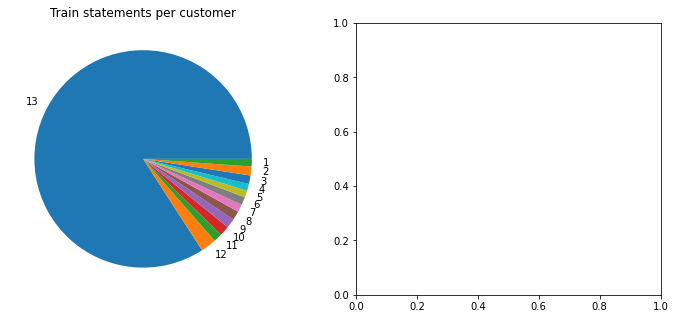

In [5]:
#Displaying the number statements per customer:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)

Text(0.5, 0.93, 'Categorical features')

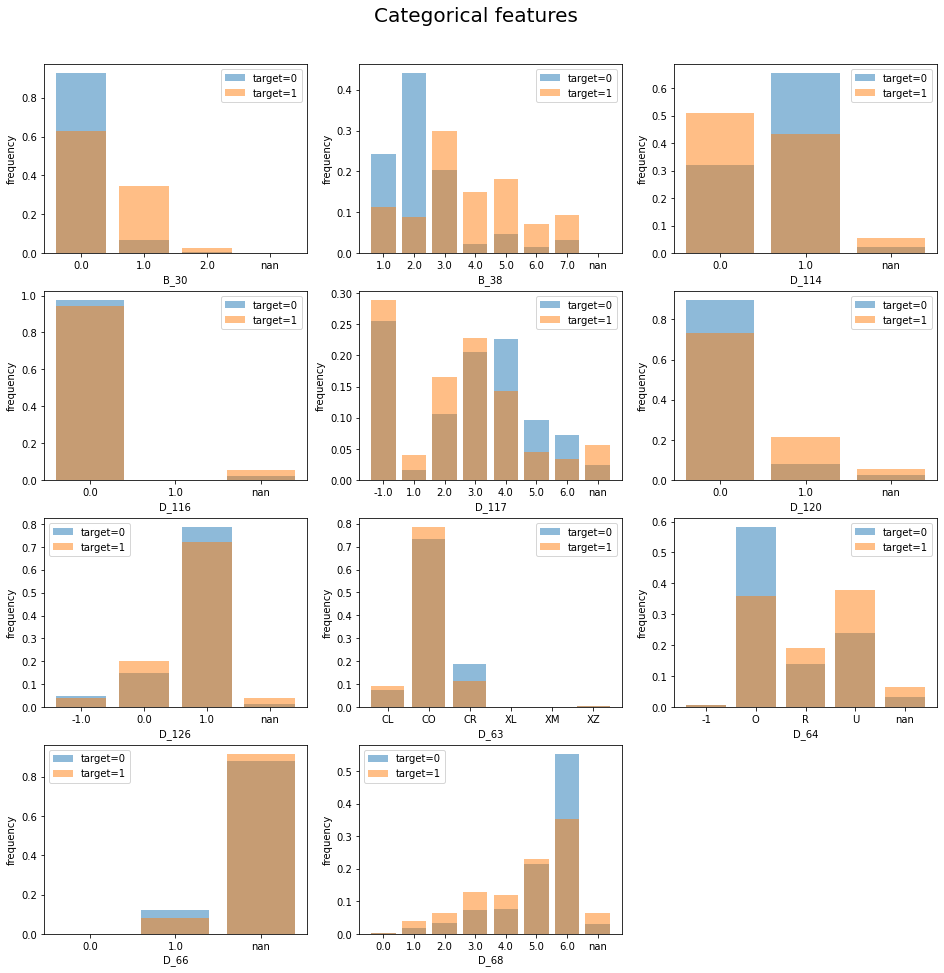

In [6]:
#Visualizing tthe categorical variables
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)

In [7]:
#Keeping the columns with atleast 70% of the values in them
train = train.dropna(axis=1, thresh=int(0.70 * len(train)))
train.shape

(5531451, 160)

In [8]:
# There are multiple transactions. We'll consider the latest transactions from each customer.
# Latest transaction may have missing values, we will perform forward fill for those missing values.
# We do a backfill if the first row happens to be Na

train=train.set_index(['customer_ID'])
train=train.ffill().bfill()
train=train.reset_index()
train=train.groupby('customer_ID').tail(1)
train=train.set_index(['customer_ID'])

# Drop date column since it is no longer relevant

train.drop(['S_2'],axis=1,inplace=True)

# Check for number of rows
train.shape

(458913, 158)

In [9]:
# Perform one-hot encoding for D_63 and D_64
train_D63 = pd.get_dummies(train[['D_63']])
train = pd.concat([train, train_D63], axis=1)
train = train.drop(['D_63'], axis=1)

train_D64 = pd.get_dummies(train[['D_64']])
train = pd.concat([train, train_D64], axis=1)
train = train.drop(['D_64'], axis=1)

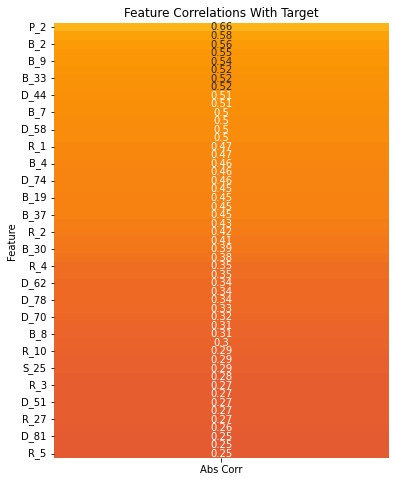

In [10]:
#Feature correlations with target
correlations = train.corrwith(train['target']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,8))
sns.heatmap(sorted_correlations.iloc[1:].to_frame()[sorted_correlations>=.25], cmap='inferno', annot=True, vmin=-1, vmax=1, ax=ax, cbar=False)

plt.ylabel('Feature')
plt.title('Feature Correlations With Target')
del correlations, sorted_correlations
plt.show()

In [11]:
# We still have large number of columns, lets remove columns with low correlation(<0.4) to the target
train.drop(train.columns[train.corrwith(train['target']).abs()<0.4],axis=1,inplace=True)

In [12]:
train.shape

(458913, 27)

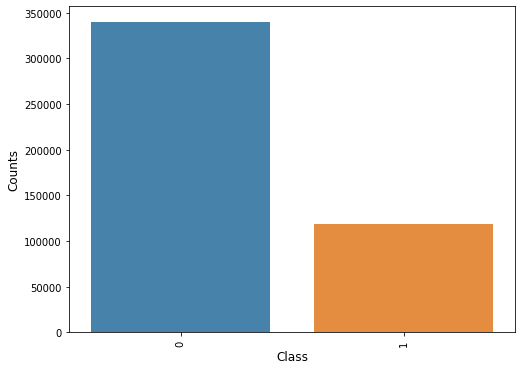

In [13]:
label_counts = train['target'].value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [14]:
y = train['target']
X = train.drop(['target'],axis=1)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26,stratify=y)

print("X_train Training Data Size :",X_train.shape[0])
print("X_test Testing Data Size   :",X_test.shape[0])

X_train Training Data Size : 367130
X_test Testing Data Size   : 91783


# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression()
%time model.fit(X_train,y_train)

CPU times: user 19.1 s, sys: 9.92 s, total: 29.1 s
Wall time: 7.81 s


LogisticRegression()

In [17]:
predict = model.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("Accuracy Score ",accuracy_score(predict,y_test))
confusion_matrix(predict,y_test)

Accuracy Score  0.8797816589128705


array([[63265,  6282],
       [ 4752, 17484]])

# Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
%time clf.fit(X_train,y_train)

CPU times: user 7min 55s, sys: 328 ms, total: 7min 56s
Wall time: 7min 56s


RandomForestClassifier()

In [20]:
predict = clf.predict(X_test)

In [21]:
print("Accuracy Score ",accuracy_score(predict,y_test))
confusion_matrix(predict,y_test)

Accuracy Score  0.8834860486146672


array([[62981,  5658],
       [ 5036, 18108]])

# Gradient Boosting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
XB = GradientBoostingClassifier(max_depth = 10,n_estimators=20,verbose=True)
%time XB.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0329            4.73m
         2           0.9481            4.44m
         3           0.8801            4.19m
         4           0.8244            3.95m
         5           0.7774            3.70m
         6           0.7374            3.46m
         7           0.7031            3.35m
         8           0.6734            3.20m
         9           0.6474            2.91m
        10           0.6247            2.63m
        20           0.4992            0.00s
CPU times: user 5min 7s, sys: 31.7 ms, total: 5min 7s
Wall time: 5min 7s


GradientBoostingClassifier(max_depth=10, n_estimators=20, verbose=True)

In [23]:
predict = XB.predict(X_test)

In [24]:
print("Accuracy Score ",accuracy_score(predict,y_test))
confusion_matrix(predict,y_test)

Accuracy Score  0.8832899338657486


array([[63484,  6179],
       [ 4533, 17587]])

# Test Data 

In [25]:
# list_of_columns=list(train.columns)
# list_of_columns.remove('target')
# list_of_columns.append('customer_ID')

# test = pd.read_parquet('../input/amex-parquet/test_data.parquet',columns=list_of_columns)
# test.head()

In [26]:
# test=test.set_index(['customer_ID'])
# test=test.ffill().bfill()
# test=test.reset_index()
# test=test.groupby('customer_ID').tail(1)
# test=test.set_index(['customer_ID'])

In [27]:
# test.columns

In [28]:
# test_prediction = clf.predict_proba(test) 

In [29]:
# # Retrieve the probability of default
# y_predict_final = test_prediction[:,1]

# # Reset index of test
# test = test.reset_index()

# # Merge the prediction and customer_ID into submission dataframe
# submission = pd.DataFrame({"customer_ID":test.customer_ID,"prediction":y_predict_final})

# submission.to_csv('submission.csv', index=False)